In [71]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import cross_val_score 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval 
from hyperopt.early_stop import no_progress_loss

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV


df = pd.read_csv("data/train.csv")
df = df.iloc[:, 1:]
submission = pd.read_csv("data/test.csv")
submission = submission.iloc[:, 1:]

#### Data Exploration

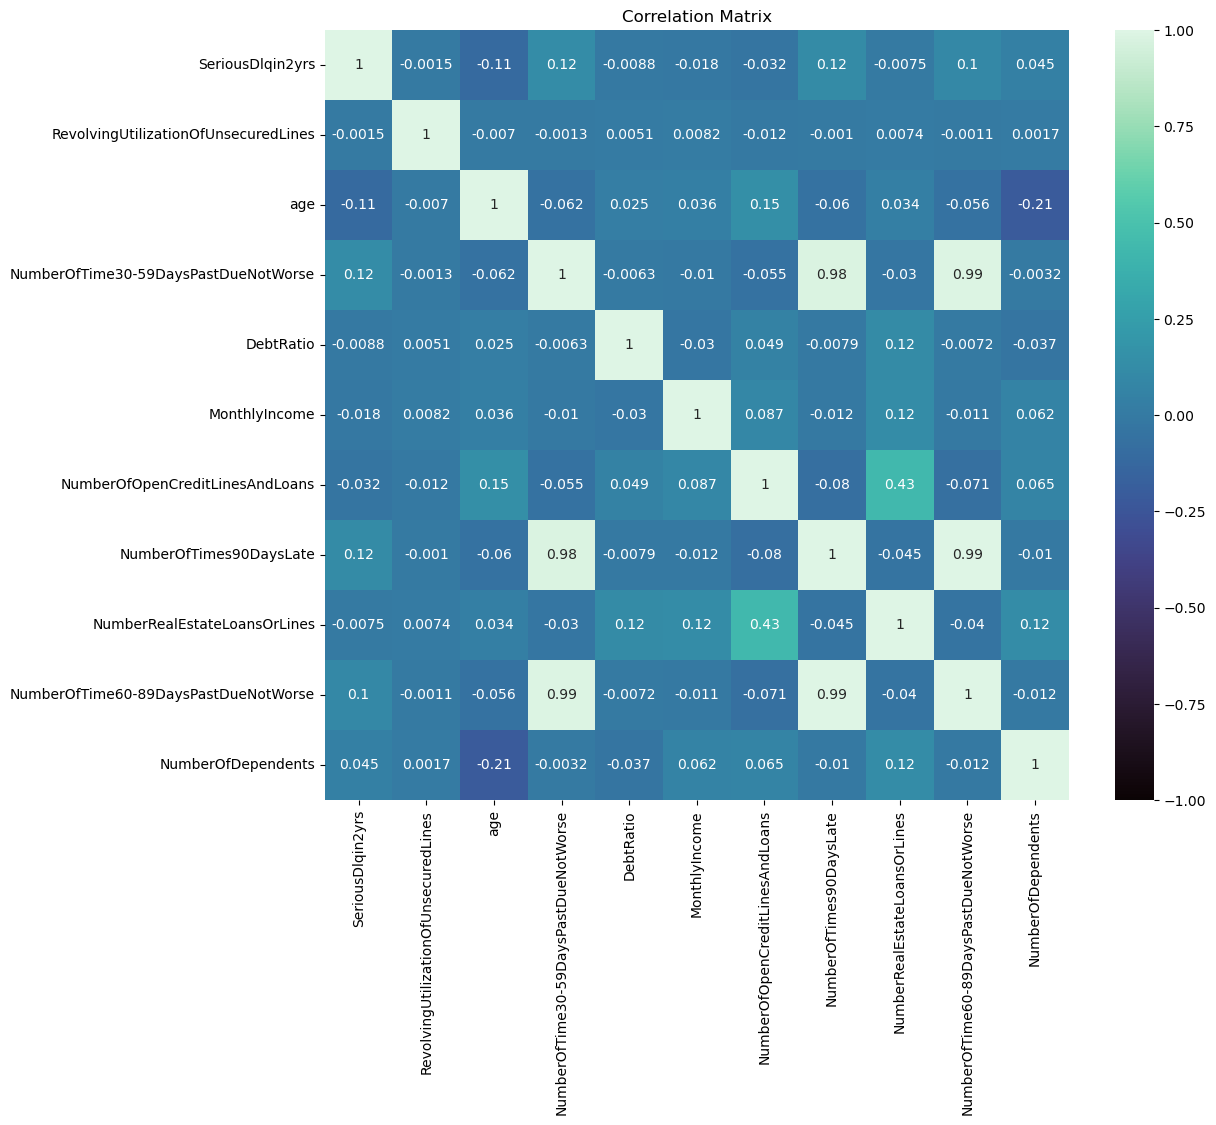

In [72]:
corr = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Matrix')
plt.show()

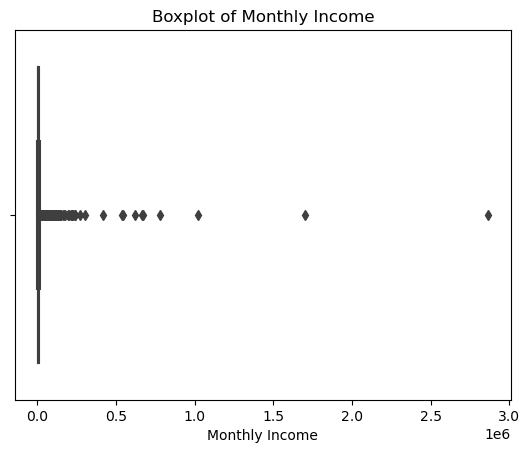

In [3]:
sns.boxplot(x=df['MonthlyIncome'])
plt.xlabel('Monthly Income')
plt.title('Boxplot of Monthly Income')

plt.show()


#### Preprocessing

In [73]:
#normally do a 20% test size, however for the submission we will use the entire dataset
#X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'SeriousDlqin2yrs'], df.loc[:, df.columns == 'SeriousDlqin2yrs'], test_size=0.2, shuffle=True)

X_train = df.loc[:, df.columns != 'SeriousDlqin2yrs']
y_train = df.loc[:, df.columns == 'SeriousDlqin2yrs']
X_submission = submission

In [74]:
# Standardize the data
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)
X_submission = scaler.transform(X_submission)

X_train = pd.DataFrame(X_train)
#X_test = pd.DataFrame(X_test)
X_submission = pd.DataFrame(X_submission)

In [75]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32).values.ravel()
#X_test = X_test.astype(np.float32)
#y_test = y_test.astype(np.float32).values.ravel()
X_submission = X_submission.astype(np.float32)

In [76]:
X_train=X_train.fillna(X_train.median())
#X_test=X_test.fillna(X_test.median())
X_submission=X_submission.fillna(X_submission.median())

#### xGBoost

In [8]:
clf_3 = xgb.XGBClassifier(colsample_bytree = 0.5, 
                        gamma = 5, max_depth = 4, 
                        min_child_weight = 1, n_estimators = 10000, 
                        reg_alpha = 10, 
                        reg_lambda = 0.5,
                        scale_pos_weight = 14,
                        eta= 0.01, nthread=-1, seed=123)
clf_3.fit(X_train, y_train)

pred_3 = clf_3.predict(X_test)

cm = confusion_matrix(y_test, pred_3, labels=clf_3.classes_)


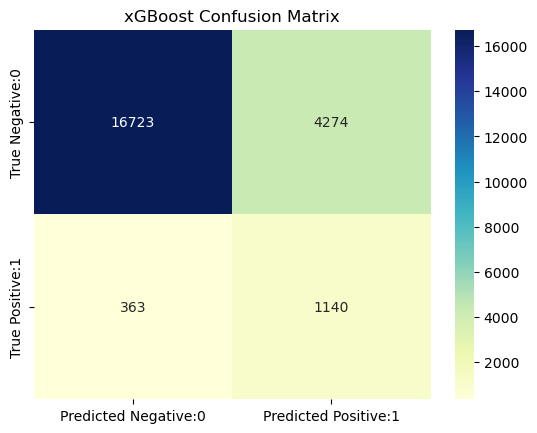

In [9]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Negative:0', 'Predicted Positive:1'], 
                                 index=['True Negative:0', 'True Positive:1'])


ax = plt.axes()
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title('xGBoost Confusion Matrix')
plt.show()


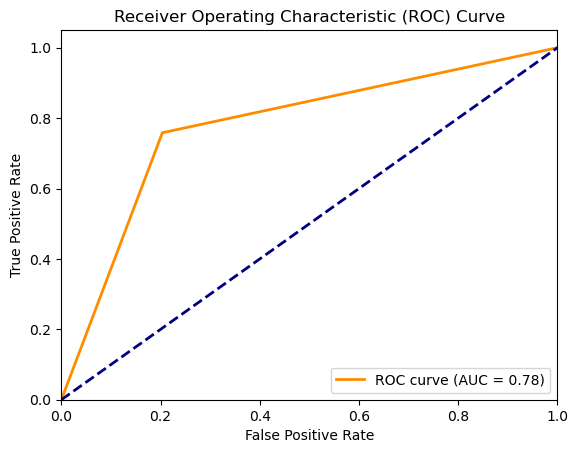

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, pred_3)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


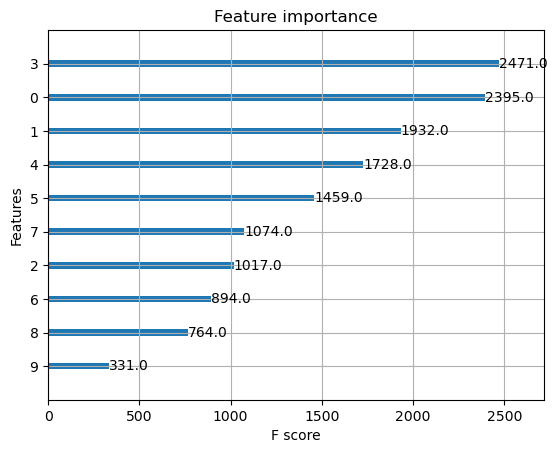

In [12]:
xgb.plot_importance(clf_3)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

#### TUNE PARAMETERS

In [ ]:
xgb_model = XGBClassifier(colsample_bytree = 0.5, 
                        gamma = 5, max_depth = 8, 
                        min_child_weight = 1, n_estimators = 10000, 
                        reg_alpha = 10, 
                        reg_lambda = 0.5,
                        scale_pos_weight = 14,
                        eta= 0.01, nthread=-1, seed=123)

test_params = {
 'scale_pos_weight':np.arange(1, 55, 1),
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params, verbose=3, scoring = 'roc_auc')
model.fit(X_train, y_train)
print(model.best_params_)

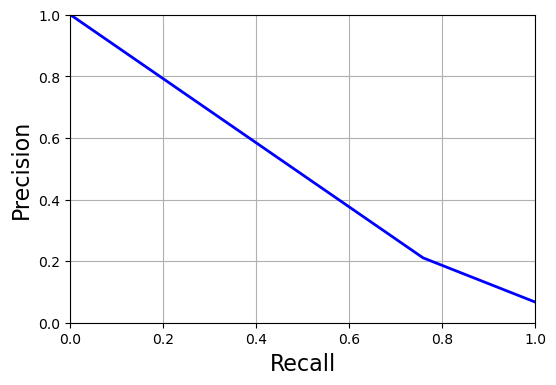

In [13]:
# Plot precision recall curve for current best model. 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_3)
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

#### Logistic Regression

In [14]:
clf = LogisticRegression(class_weight='balanced', max_iter=10000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86     20997
         1.0       0.17      0.63      0.27      1503

    accuracy                           0.77     22500
   macro avg       0.57      0.71      0.57     22500
weighted avg       0.91      0.77      0.82     22500



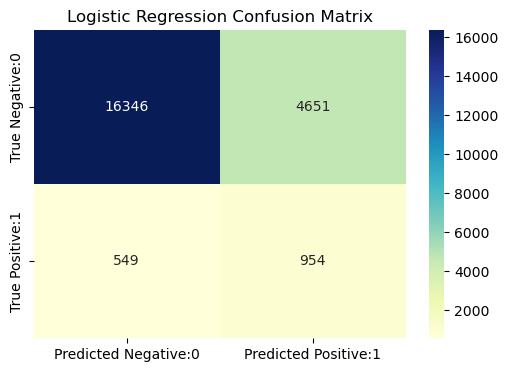

In [15]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Negative:0', 'Predicted Positive:1'], 
                                 index=['True Negative:0', 'True Positive:1'])


ax = plt.axes()
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title('Logistic Regression Confusion Matrix')
plt.show()


#### Random Forests

In [37]:
rf = RandomForestClassifier(max_depth=110, min_samples_split=10, random_state = 123, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     20997
         1.0       0.44      0.34      0.38      1503

    accuracy                           0.93     22500
   macro avg       0.70      0.65      0.67     22500
weighted avg       0.92      0.93      0.92     22500



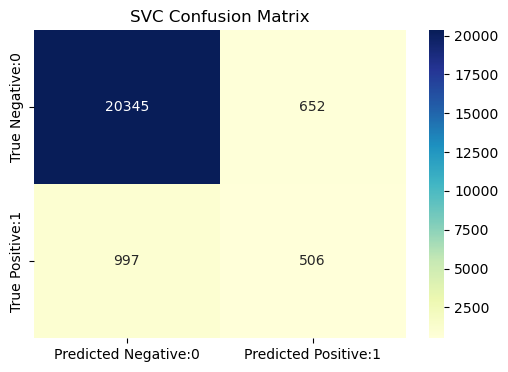

In [38]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Negative:0', 'Predicted Positive:1'], 
                                 index=['True Negative:0', 'True Positive:1'])


ax = plt.axes()
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title('SVC Confusion Matrix')
plt.show()


#### SVC

In [16]:
svm = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91     20997
         1.0       0.24      0.65      0.35      1503

    accuracy                           0.84     22500
   macro avg       0.61      0.75      0.63     22500
weighted avg       0.92      0.84      0.87     22500



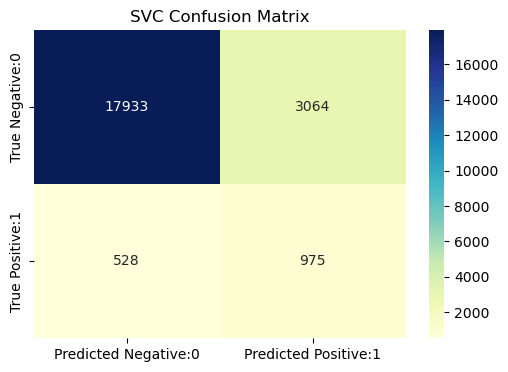

In [17]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Negative:0', 'Predicted Positive:1'], 
                                 index=['True Negative:0', 'True Positive:1'])


ax = plt.axes()
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title('SVC Confusion Matrix')
plt.show()


#### Voting Classifier

In [77]:
xgb_cf = xgb.XGBClassifier(colsample_bytree = 0.5, 
                        gamma = 5, max_depth = 4, 
                        min_child_weight = 1, n_estimators = 10000, 
                        reg_alpha = 10, 
                        reg_lambda = 0.5,
                        scale_pos_weight = 14,
                        eta= 0.01, nthread=-1)
lr_cf = LogisticRegression(C= 100, class_weight='balanced', max_iter=10000, n_jobs=-1)
rf_cf = RandomForestClassifier(max_depth=110, min_samples_split=10, n_jobs=-1, class_weight='balanced')
svm_cf =SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')

In [79]:
vote = VotingClassifier (estimators = [('xgb_cf', xgb_cf), ('lr_cf', lr_cf), ('rf_cf', rf_cf), ('svm_cf', svm_cf)],
                         voting='hard', weights=[2,1,1,1], n_jobs=-1)
vote.fit(X_train,y_train)
y_pred = vote.predict(X_submission)
#cm = confusion_matrix(y_test, y_pred)
#print(classification_report(y_test, y_pred))

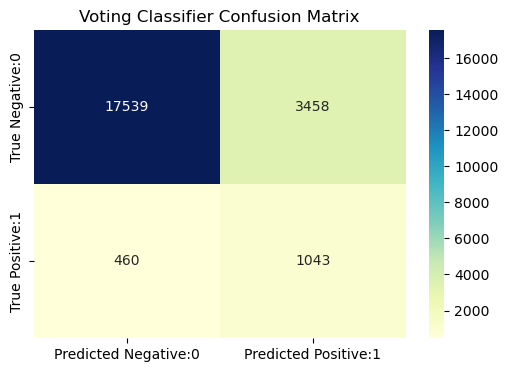

In [40]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Negative:0', 'Predicted Positive:1'], 
                                 index=['True Negative:0', 'True Positive:1'])


ax = plt.axes()
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title('Voting Classifier Confusion Matrix')
plt.show()


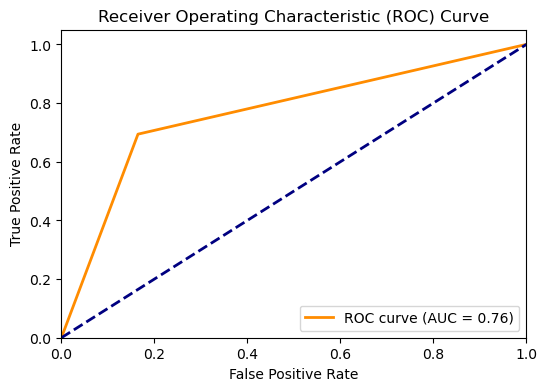

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [93]:
import pandas as pd

# Create a DataFrame with the y_pred values in the second column
df = pd.DataFrame(y_pred)

# Save the DataFrame to a CSV file
df.to_csv('output.csv', index=True)

